### Example 5 - Important Concepts: Build a Liquidity Filter

In this example, we'll create a simple liquidity filter which finds liquid types for a given region
based on configurable criteria.  This is the simplest of our introductory examples, but also one
of the most important for future analysis.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
# EveKit imports
from evekit.reference import Client
from evekit.util import convert_raw_time

In [2]:
# We'll use The Forge region to check for liquid assert types.  The set of liquid types
# can vary from day to day.  So, we'll also specify a date range and focus on finding
# types which are liquid over an acceptable portion of our date range.  For this example,
# we'll use a 90 day date range backwards from our reference date.
#
# This cell initializes these settings.
#
sde_client = Client.SDE.get()
region_query = "{values: ['The Forge']}"
region_id = sde_client.Map.getRegions(regionName=region_query).result()[0][0]['regionID']
compute_date = convert_raw_time(1483228800000) # 2017-01-01 12:00 AM UTC
date_range = pd.date_range(compute_date - datetime.timedelta(days=90), compute_date)
print("Using region_id=%d from %s to %s" % (region_id, str(date_range[0]), str(date_range[-1])))

Using region_id=10000002 from 2016-10-03 00:00:00 to 2017-01-01 00:00:00


In [3]:
#
# WARNING: this cell will take some time to evaluate if your connection is slow
#
# We'll find liquid types by analyzing market history which we download to local storage
# for convenience.  This isn't mandatory and if you'd prefer to load everything online on demand,
# you can remove the "local_storage" argument from the market history functions below.
# However, we strongly recommend downloading history to local storage to allow you to iterate
# more easily as you experiment with different filters.
#
from evekit.online.Download import download_market_history_range
download_market_history_range(date_range, ".", dict(skip_missing=True, tree=True, verbose=True))

In [4]:
# We'll need all market types for this example.  We'll retrieve the set of market types from the SDE.
# The EveKit libraries include a convenience function for iterating over a large set of results
# (like the set of all market types).
#
market_types = Client.SDE.load_complete(sde_client.Inventory.getTypes, marketGroupID="{start: 0, end: 1000000000}")
market_types = [x['typeID'] for x in market_types]
len(market_types)

11677

In [5]:
# Now we'll load market history into a DataFrame.  Note that we're loading for all types in a single
# region for 90 days so this may take a few minutes.  You can reduce the set of types if memory or 
# speed is an issue for your installation.
#
from evekit.marketdata import MarketHistory
market_history = MarketHistory.get_data_frame(dates=date_range, types=market_types, regions=[region_id], 
                                              config=dict(local_storage=".", tree=True, skip_missing=True, verbose=True))

Retrieving 2016-10-03 00:00:00...done
Retrieving 2016-10-04 00:00:00...done
Retrieving 2016-10-05 00:00:00...done
Retrieving 2016-10-06 00:00:00...done
Retrieving 2016-10-07 00:00:00...done
Retrieving 2016-10-08 00:00:00...done
Retrieving 2016-10-09 00:00:00...done
Retrieving 2016-10-10 00:00:00...done
Retrieving 2016-10-11 00:00:00...done
Retrieving 2016-10-12 00:00:00...done
Retrieving 2016-10-13 00:00:00...done
Retrieving 2016-10-14 00:00:00...done
Retrieving 2016-10-15 00:00:00...done
Retrieving 2016-10-16 00:00:00...done
Retrieving 2016-10-17 00:00:00...done
Retrieving 2016-10-18 00:00:00...done
Retrieving 2016-10-19 00:00:00...done
Retrieving 2016-10-20 00:00:00...done
Retrieving 2016-10-21 00:00:00...done
Retrieving 2016-10-22 00:00:00...done
Retrieving 2016-10-23 00:00:00...done
Retrieving 2016-10-24 00:00:00...done
Retrieving 2016-10-25 00:00:00...done
Retrieving 2016-10-26 00:00:00...done
Retrieving 2016-10-27 00:00:00...done
Retrieving 2016-10-28 00:00:00...done
Retrieving 2

In [6]:
# We'll want to experiment with various liquidity filters.  So we'll create a generic 
# liquidity evaluator which accepts a market history object and a generic filter.
# The evaluator will apply the filter to each asset type in each region and record which
# types the filter marks as liquid.  The result of the evaluator is a map from region to
# the set of liquid types in that region.
#
# The signature of the liquidity filter is:
#
# boolean liquidp(region_id, type_id, history)
#
# where the history DataFrame will be pre-filtered to the selected region and type.
# The filter should return True if the given type should be considered liquid in 
# the given region, and False otherwise.
#
def liquid_types(history, liquidp, verbose=False):
    # Result is map from region to set of liquid types for that region
    # Iterate through all types contained in the history object
    liquid_map = {}
    count = 0
    # Iterate through all regions and types
    for next_region in history.region_id.unique():
        liquid_set = set()
        by_region = history[history.region_id == next_region]
        for next_type in by_region.type_id.unique():
            by_type = by_region[by_region.type_id == next_type]
            if liquidp(next_region, next_type, by_type):
                liquid_set.add(next_type)
            count += 1
            if count % 1000 == 0 and verbose:
                print("Tested %d (region, type) pairs" % count)
        liquid_map[next_region] = liquid_set
    return liquid_map

In [7]:
# There are many ways to define liquidity.  For our first filter, we'll treat a type as liquid if:
#
# 1. Market history exists for a minimum number of days
# 2. Each day of market history meets an order count threshold
# 3. Each day of market history meets an ISK volume threshold
#
# It is convenient to express our filter as a functor (a function which returns a function) so that
# it is easier to experiment with different thresholds.
#
def liquidity_filter(min_days, min_order_count, min_isk_volume):
    def liquidp(region_id, type_id, history):
        return len(history) >= min_days and \
               len(history[history.order_count < min_order_count]) == 0 and \
               len(history[(history.avg_price * history.volume) < min_isk_volume]) == 0
    return liquidp

In [8]:
# Let's start with a simple parameterization.  We'll expect a liquid type to:
#
# 1. Be traded at least 70% of the days in the date range;
# 2. Have at least 100 orders a day; and,
# 3. Have at least 100m ISK of activity
#
day_min = int(len(date_range) * 0.7)
order_min = 100
volume_min = 100000000

# We can hand test our filter on a sample type.  For example, Tritanium (type 34) is almost certainly liquid over this range:
(liquidity_filter(day_min, order_min, volume_min))(region_id, 34, market_history[market_history.region_id == region_id]\
                                                                                [market_history.type_id == 34])

True

In [9]:
# Let's collect the list of all liquid types for this data.  This may take a few minutes
# to run due to the size of the data.
l_set = liquid_types(market_history, liquidity_filter(day_min, order_min, volume_min), verbose=True)

import pprint
pprint.pprint(l_set, compact=True)

Tested 1000 (region, type) pairs
Tested 2000 (region, type) pairs
Tested 3000 (region, type) pairs
Tested 4000 (region, type) pairs
Tested 5000 (region, type) pairs
Tested 6000 (region, type) pairs
Tested 7000 (region, type) pairs
Tested 8000 (region, type) pairs
Tested 9000 (region, type) pairs
Tested 10000 (region, type) pairs
{10000002: {34, 35, 36, 37, 38, 39, 40, 203, 438, 440, 448, 519, 527, 621, 1183,
            1228, 1230, 1236, 1248, 1319, 1335, 1355, 1405, 1422, 1447, 1541,
            1877, 1952, 1978, 1999, 2024, 2032, 2048, 2175, 2185, 2205, 2281,
            2299, 2301, 2303, 2333, 2364, 2404, 2410, 2446, 2456, 2466, 2488,
            2539, 2553, 2605, 2629, 2679, 2876, 2889, 2977, 3146, 3178, 3244,
            3530, 3568, 3578, 3645, 3689, 3828, 3831, 3841, 3888, 4051, 4254,
            4383, 4403, 4405, 5839, 5945, 5955, 5973, 8027, 8089, 8105, 8117,
            8433, 8517, 8641, 9668, 9728, 9772, 9832, 9834, 9842, 9848, 9899,
            9941, 9942, 9943, 9956, 10190,

In [10]:
# You can use the SDE if you want to see type names for these types as follows.
#
type_name_query = "{values:[" + ",".join(map(str, l_set[region_id])) + "]}"
type_name_results = Client.SDE.load_complete(sde_client.Inventory.getTypes, typeID=type_name_query)
pprint.pprint([x['typeName'] for x in type_name_results], compact=True)

['Tritanium', 'Pyerite', 'Mexallon', 'Isogen', 'Nocxium', 'Zydrine', 'Megacyte',
 'Scourge Cruise Missile', '1MN Afterburner II', '5MN Microwarpdrive II',
 'Warp Scrambler II', 'Gyrostabilizer II', 'Stasis Webifier II', 'Caracal',
 'Small Armor Repairer II', 'Scordite', 'Veldspar',
 'Overdrive Injector System II', 'Capacitor Flux Coil II',
 'Expanded Cargohold II', 'Reinforced Bulkheads II', 'Reactor Control Unit II',
 'Inertial Stabilizers II', 'Shield Power Relay II', 'Capacitor Power Relay II',
 'Power Diagnostic System II', 'Rapid Light Missile Launcher II',
 'Sensor Booster II', 'Tracking Computer II', 'Tracking Enhancer II',
 'Medium Capacitor Booster II', 'Cap Recharger II', 'Damage Control II',
 'Infiltrator II', 'Hammerhead II', 'Acolyte II',
 'Adaptive Invulnerability Field II', 'Kinetic Deflection Field II',
 'EM Ward Field II', 'Thermal Dissipation Field II', 'Survey Scanner II',
 'Heat Sink II', 'Light Missile Launcher II', 'Heavy Missile Launcher II',
 'Ogre II', 'Hobgobl

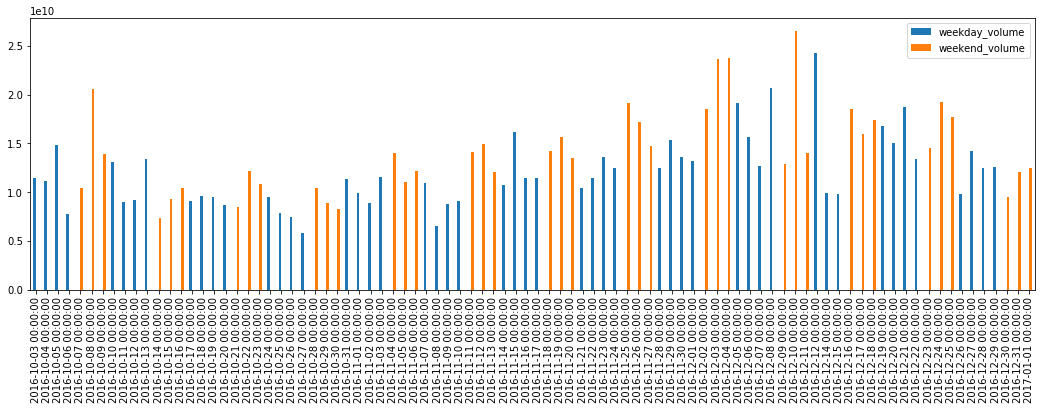

In [11]:
# Our first filter selected across the entire date range.  However, many assets are more active on weekends.
# For example, here is Tritanium ISK volume with week days and week ends (friday through saturday) 
# rendered in different colors.
#
weekends = [x for x in date_range if x.weekday() in (4,5,6)]
weekdays = [x for x in date_range if x not in weekends]
tritanium = market_history[market_history.region_id == region_id][market_history.type_id == 34].copy()
tritanium['weekday_volume'] = tritanium.volume.ix[weekdays]
tritanium['weekend_volume'] = tritanium.volume.ix[weekends]
tritanium[['weekday_volume','weekend_volume']].plot(kind='bar', figsize=[18,5])

In [12]:
# Note that weekend volume is usually slightly higher than weekday volume.  We can write a liquidity
# filter which only considers weekends as shown below. 
#
def liquidity_filter_2(min_days, min_order_count, min_isk_volume):
    def liquidp(region_id, type_id, history):
        by_weekend = history.ix[[x for x in history.index.unique() if x.weekday() in (4, 5, 6)]]
        return len(by_weekend) >= min_days and \
               len(by_weekend[by_weekend.order_count < min_order_count]) == 0 and \
               len(by_weekend[(by_weekend.avg_price * by_weekend.volume) < min_isk_volume]) == 0
    return liquidp

In [13]:
# Since there are many fewer days under consideration, we'll need to adjust our day minimum,
# but otherwise we can keep the same parameters from before.
#
day_min = int(len(weekends) * 0.7)
order_min = 100
volume_min = 100000000

# And now we can apply the filter...
l_set_2 = liquid_types(market_history, liquidity_filter_2(day_min, order_min, volume_min), verbose=True)
pprint.pprint(l_set_2, compact=True)

Tested 1000 (region, type) pairs
Tested 2000 (region, type) pairs
Tested 3000 (region, type) pairs
Tested 4000 (region, type) pairs
Tested 5000 (region, type) pairs
Tested 6000 (region, type) pairs
Tested 7000 (region, type) pairs
Tested 8000 (region, type) pairs
Tested 9000 (region, type) pairs
Tested 10000 (region, type) pairs
{10000002: {18, 34, 35, 36, 37, 38, 39, 40, 203, 230, 380, 438, 440, 448, 519,
            527, 621, 1183, 1224, 1228, 1230, 1236, 1248, 1306, 1319, 1335,
            1355, 1405, 1422, 1447, 1541, 1877, 1952, 1978, 1999, 2024, 2032,
            2048, 2175, 2185, 2195, 2205, 2281, 2299, 2301, 2303, 2333, 2364,
            2404, 2410, 2446, 2456, 2466, 2488, 2539, 2553, 2605, 2629, 2679,
            2876, 2889, 2913, 2977, 3082, 3146, 3178, 3244, 3520, 3530, 3568,
            3578, 3645, 3689, 3828, 3831, 3841, 3888, 4051, 4254, 4383, 4403,
            4405, 5839, 5945, 5955, 5973, 8027, 8089, 8105, 8117, 8433, 8517,
            8641, 9668, 9678, 9728, 9772, 9800

In [14]:
# As we might expect, there are more liquid types when we only consider weekends:
print("Full Date Range: %d  Weekends Only: %d" % (len(l_set[region_id]), len(l_set_2[region_id])))
new_liquid_types = l_set_2[region_id].difference(l_set[region_id])
type_name_query = "{values:[" + ",".join(map(str, new_liquid_types)) + "]}"
type_name_results = Client.SDE.load_complete(sde_client.Inventory.getTypes, typeID=type_name_query)
print("New liquid types:")
pprint.pprint([x['typeName'] for x in type_name_results], compact=True)

Full Date Range: 286  Weekends Only: 319
New liquid types:
['Plagioclase', 'Antimatter Charge M', 'Small Shield Extender II', 'Pyroxeres',
 'Adaptive Nano Plating II', 'Praetor II', '425mm AutoCannon II',
 '250mm Railgun II', 'Heavy Pulse Laser II',
 "Large 'Vehemence' Shockwave Charge", 'Medium YF-12a Smartbomb',
 'Social Adaptation Chip - Standard', 'Medium Shield Booster II',
 '100MN Afterburner II', 'Scorch M', 'Helium Isotopes', 'Massive Scordite',
 "7th Tier Overseer's Personal Effects", 'Target Painter II',
 'Datacore - Electromagnetic Physics', 'Republic Fleet Fusion M',
 'Imperial Navy Multifrequency M', 'Caldari Navy Scourge Rocket', 'Garde II',
 'Tengu', 'Small Trimark Armor Pump I',
 'Small Hyperspatial Velocity Optimizer II',
 'Small Ancillary Current Router II', 'Small Anti-EM Screen Reinforcer II',
 'Medium Anti-Thermal Screen Reinforcer II',
 'Medium Core Defense Field Purger I', 'Medium Ancillary Shield Booster',
 'Omnidirectional Tracking Enhancer II']


Although this example was relatively simple, we'll see in later chapters that most trading strategies
only work well on liquid assets.  Your time will be well spent finding a liquidity filter that works
well for your strategies.